### WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [4]:
# ignore warnings
import warnings

warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

### The dataset we are going to deal with is that of facial pose.

## Lets take a single image name ans its annotations from csv files

In [5]:
landmarks_frame = pd.read_csv("../data/faces/face_landmarks.csv")
n = 65
image_name = landmarks_frame.iloc[n,0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float')
landmarks

array([ 32.,  65.,  33.,  76.,  34.,  86.,  34.,  97.,  37., 107.,  41.,
       116.,  50., 122.,  61., 126.,  72., 127.,  83., 126.,  95., 123.,
       107., 119., 115., 111., 118., 101., 120.,  91., 122.,  80., 122.,
        68.,  39.,  52.,  45.,  46.,  53.,  44.,  61.,  46.,  68.,  49.,
        82.,  49.,  90.,  45.,  98.,  44., 106.,  46., 112.,  52.,  74.,
        57.,  74.,  63.,  74.,  69.,  74.,  75.,  67.,  83.,  70.,  84.,
        74.,  85.,  78.,  84.,  82.,  83.,  47.,  61.,  51.,  57.,  58.,
        57.,  63.,  61.,  57.,  63.,  51.,  63.,  87.,  62.,  93.,  58.,
        98.,  58., 103.,  61.,  99.,  63.,  93.,  63.,  55.,  98.,  63.,
        96.,  70.,  94.,  75.,  95.,  80.,  94.,  86.,  95.,  94.,  99.,
        86., 103.,  79., 105.,  74., 105.,  69., 105.,  62., 103.,  58.,
        99.,  70.,  98.,  74.,  98.,  79.,  98.,  91.,  99.,  79.,  99.,
        74.,  99.,  69.,  99.])

In [9]:
landmarks.shape, landmarks.ndim

((136,), 1)

In [10]:
landmarks = landmarks.reshape(-1, 2)
landmarks

array([[ 32.,  65.],
       [ 33.,  76.],
       [ 34.,  86.],
       [ 34.,  97.],
       [ 37., 107.],
       [ 41., 116.],
       [ 50., 122.],
       [ 61., 126.],
       [ 72., 127.],
       [ 83., 126.],
       [ 95., 123.],
       [107., 119.],
       [115., 111.],
       [118., 101.],
       [120.,  91.],
       [122.,  80.],
       [122.,  68.],
       [ 39.,  52.],
       [ 45.,  46.],
       [ 53.,  44.],
       [ 61.,  46.],
       [ 68.,  49.],
       [ 82.,  49.],
       [ 90.,  45.],
       [ 98.,  44.],
       [106.,  46.],
       [112.,  52.],
       [ 74.,  57.],
       [ 74.,  63.],
       [ 74.,  69.],
       [ 74.,  75.],
       [ 67.,  83.],
       [ 70.,  84.],
       [ 74.,  85.],
       [ 78.,  84.],
       [ 82.,  83.],
       [ 47.,  61.],
       [ 51.,  57.],
       [ 58.,  57.],
       [ 63.,  61.],
       [ 57.,  63.],
       [ 51.,  63.],
       [ 87.,  62.],
       [ 93.,  58.],
       [ 98.,  58.],
       [103.,  61.],
       [ 99.,  63.],
       [ 93.,

In [11]:
print(f"Image name : {image_name}")
print(f"Landmarks shape : {landmarks.shape}")
print(f"First 4 landmarks : {landmarks[:4]}")

Image name : person-7.jpg
Landmarks shape : (68, 2)
First 4 landmarks : [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [14]:
# A simple helper function to show image and its landmarks
def show_landmarks(image, landmarks):
    "Show image with landmarks"
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, c='r',marker='*')
    plt.pause(0.001) # pause do that the plots are updated


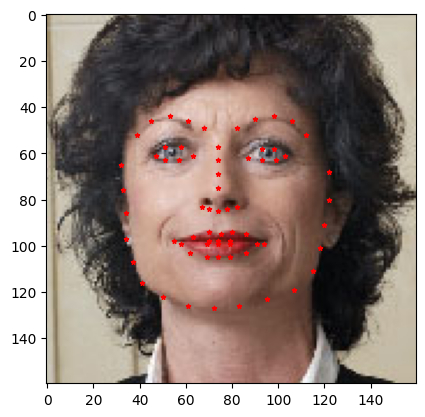

In [15]:
plt.figure()
show_landmarks(io.imread(os.path.join('../data/faces/', image_name)), landmarks)
plt.show()


## Lets Create a Custom Class for Loading our Datasets

In [16]:
class FaceLandMarksDataset(Dataset):
    "Face landmarks Dataset"
    def __init__(self, csv_file, root_dir, transform=None) -> None:
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir,self.landmarks_frame.iloc[idx,0])
        image = io.imread(image_name)
        landmarks = self.landmarks_frame.iloc[idx,1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {'image':image,'landmarks':landmarks}

        if self.transform:
            sample = self.transform(sample)
        return sample

0 (324, 215, 3) (68, 2)


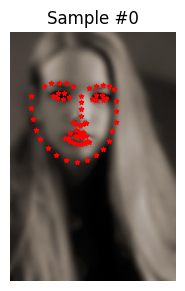

1 (500, 333, 3) (68, 2)


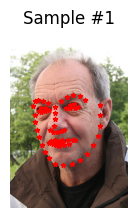

2 (250, 258, 3) (68, 2)


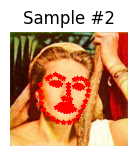

3 (434, 290, 3) (68, 2)


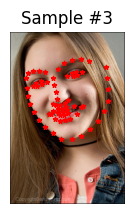

In [23]:
face_dataset = FaceLandMarksDataset(csv_file='../data/faces/face_landmarks.csv',root_dir='../data/faces/')
fig = plt.figure(figsize=(8,8))

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        break
plt.show()

### Transforms : Not all images are of same size

In [25]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

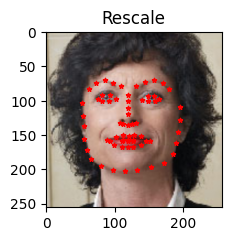

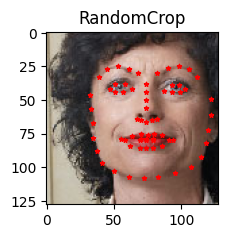

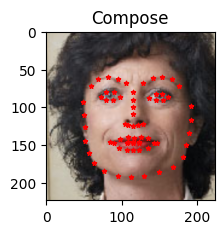

In [26]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()